# Web Scraping and Data Exploration Project

The purpose of this project is to extract some insights into the Properties Market Prices in Santander - Colombia. 

First, let's begin by creating our own dataset by scraping [Mercado libre](https://www.mercadolibre.com.co/) using BeautifulSoup. This time, we are interested in data about Properties in the department of Santander - Colombia.

Then, let's conduct some data cleaning and transformation, such as low-quality data removal, information extraction, and imputation.

Later, some data exploration through data visualization.

Last, getting some insights through visualization. Some Q&A.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from csv import writer
from collections import OrderedDict

## Web Scraping

In [2]:
filename = "fincas_sder_mercado_libre.csv"
parser = "html.parser"
header = ["Property_type", "Description", "Location", "Price", "Features"]

In [3]:
def write_headers():
    with open(filename,"w", encoding="utf8", newline="") as f:
        my_writer = writer(f)
        my_writer.writerow(header)
        
def scrap_data(tag_category, class_name):
    lists = soup.find_all(tag_category, class_=class_name)
    with open(filename,"a+", encoding="utf8", newline="") as f:
        my_writer = writer(f)
        for ilist in lists:
            item_type = ilist.find("span", class_="ui-search-item__subtitle").get_text(strip=True)                    
            description = ilist.find("h2", class_="ui-search-item__group__element").get_text().strip()
            location= ilist.find("span", class_="ui-search-item__location").get_text().strip()
            price = ilist.find("span", class_="price-tag-text-sr-only").get_text().strip()
            features = [i.get_text().strip() for i in ilist.find_all("li", class_="ui-search-card-attributes__attribute")]
            info = [item_type, description, location, price, features]
            my_writer.writerow(info)


In [4]:
n_pages = 37
items_per_page = 48
write_headers()
for i in range(n_pages):
    if i == 0:
        url = f"https://listado.mercadolibre.com.co/inmuebles/venta/santander/_NoIndex_True"
    else:
        url = f"https://listado.mercadolibre.com.co/inmuebles/venta/santander/_Desde_{i*items_per_page + 1}_NoIndex_True"    
    try:
        page = requests.get(url)
        page.raise_for_status()
        soup = BeautifulSoup(page.content, parser)
        scrap_data("div", "ui-search-result__content-wrapper")
    except Exception as e:
        print(e)

### Check the raw scraped data

In [6]:
property_df = pd.read_csv(filename)
property_df.head(5)

,Property_type,Description,Location,Price,Features
0,Lote y casalote en venta,Lote 100% Plan En Espectacular Condominio Ruit...,"2vhg+wh Girón, Santander, Colombia, Girón, San...",438000000 pesos,['348 m² totales']
1,Finca en venta,Finca Zapatoca Cafe Citricos Via A La Fuente A...,"Via A La Fuente 12 Km Del Pueblo 3014052546, Z...",255000000 pesos,"['450 m² cubiertos', '4 habs.']"
2,Finca en venta,"Finca 7 Hectáreas, Maderable Y Productiva En E...","Bucaramanga Vía Cúcuta Km 22, Tona, Santander",2700 pesos,"['120 m² cubiertos', '3 habs.']"
3,Apartamento en venta,Apartamento En Venta En Bucaramanga Centro,"Centro, Bucaramanga, Santander",210000000 pesos,"['87 m² cubiertos', '3 habs.']"
4,Lote y casalote en venta,Lotes En Condominio Mirador Del Lago Bucaramanga,"Mesa De Los Santos, Bucaramanga, Santander",144000000 pesos,"['1,486 m² totales']"


In [7]:
pd.options.display.float_format = '{:.1f}'.format
property_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1769 entries, 0 to 1768
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Property_type  1769 non-null   object
 1   Description    1769 non-null   object
 2   Location       1769 non-null   object
 3   Price          1769 non-null   object
 4   Features       1769 non-null   object
dtypes: object(5)
memory usage: 69.2+ KB


## Data cleaning, Transformation, Imputation

In [8]:
# Rename columns
property_df.rename(columns = {"Property_type":"Property_Type"}, inplace = True)

property_df["Price"] = property_df["Price"].apply(lambda x: x.rstrip(" pesos"))
property_df[["Area","Rooms"]]  = property_df["Features"].str.split(", ",1, expand = True)
property_df["Area"]  = property_df["Area"].str.replace(",","")

In [9]:
swap_idx = property_df[property_df["Area"].str.contains("hab")].index
property_df.loc[swap_idx,"Area"], property_df.loc[swap_idx,"Rooms"] = property_df.loc[swap_idx,"Rooms"], property_df.loc[swap_idx,"Area"]
property_df["Property_Type"] = property_df["Property_Type"].str.replace(" en venta","")

In [10]:
property_df[["Area","Rooms"]] = property_df[["Area","Rooms"]].apply(lambda x: x.str.extract('(\d+)', expand = False))
property_df.drop(columns=["Features"], inplace=True)

In [13]:
property_df["Location"] = property_df["Location"].str.replace(",\s*Santander\s*[0-9]*[A-Z]*\s*","")

C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16208\66483620.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  property_df["Location"] = property_df["Location"].str.replace(",\s*Santander\s*[0-9]*[A-Z]*\s*","")


In [14]:
property_df[["Price", "Area", "Rooms"]] = property_df[["Price", "Area", "Rooms"]].apply(pd.to_numeric)
location_df = property_df["Location"].str.replace("\s*Santander","").str.split(",", expand = True).fillna("")

C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16208\3928268762.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  location_df = property_df["Location"].str.replace("\s*Santander","").str.split(",", expand = True).fillna("")


In [15]:
alpha_filter = location_df.apply(lambda x: x.str.replace("\s*","").str.isalpha())
property_df["City_name"] = location_df[alpha_filter].fillna("").T.agg("".join).str.replace("\s*Colombia","")
property_df["Address"] = location_df[-alpha_filter].fillna("").T.agg("".join).str.replace("\s*Colombia","")

C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16208\3842240681.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  alpha_filter = location_df.apply(lambda x: x.str.replace("\s*","").str.isalpha())
C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16208\3842240681.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  property_df["City_name"] = location_df[alpha_filter].fillna("").T.agg("".join).str.replace("\s*Colombia","")
C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16208\3842240681.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  property_df["Address"] = location_df[-alpha_filter].fillna("").T.agg("".join).str.replace("\s*Colombia","")


In [16]:
property_df[["City_name","Address"]] = property_df[["City_name","Address"]].apply(lambda x: x.str.strip())

In [17]:
property_df["City_name"] = property_df["City_name"].str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(" ")

In [18]:
property_df

,Property_Type,Description,Location,Price,Area,Rooms,City_name,Address
0,Lote y casalote,Lote 100% Plan En Espectacular Condominio Ruit...,"2vhg+wh Girón, Colombia, Girón",438000000,348.0,NaN,Girón,2vhg+wh Girón
1,Finca,Finca Zapatoca Cafe Citricos Via A La Fuente A...,"Via A La Fuente 12 Km Del Pueblo 3014052546, Z...",255000000,450.0,4.0,Zapatoca,Via A La Fuente 12 Km Del Pueblo 3014052546
2,Finca,"Finca 7 Hectáreas, Maderable Y Productiva En E...","Bucaramanga Vía Cúcuta Km 22, Tona",2700,120.0,3.0,Tona,Bucaramanga Vía Cúcuta Km 22
3,Apartamento,Apartamento En Venta En Bucaramanga Centro,"Centro, Bucaramanga",210000000,87.0,3.0,Centro Bucaramanga,
4,Lote y casalote,Lotes En Condominio Mirador Del Lago Bucaramanga,"Mesa De Los Santos, Bucaramanga",144000000,1486.0,NaN,Mesa De Los Santos Bucaramanga,
...,...,...,...,...,...,...,...,...
1764,Casa,Casa Linda En Barrancabermeja /1 Piso,"Calle 35 #23-51, Barrancabermeja",460000000,NaN,3.0,Barrancabermeja,Calle 35 #23-51
1765,Apartamento,Venta De Apartamento En San Alonso,"Calle 20#31-78 #sn-sn, San Alonso, Bucaramanga",290000000,85.0,3.0,San Alonso Bucaramanga,Calle 20#31-78 #sn-sn
1766,Apartamento,Apartamento En Venta En Excelente Zona Residen...,"Portal De San Sebastian, Calle Real ##6-72, Bu...",210000000,57.0,3.0,Portal De San Sebastian Bucaramanga,Calle Real ##6-72
1767,Negocio,"Se Vende Local De Ferretería, Eléctricos, Cons...","Bulevar Bolívar, Bucaramanga, Colombia, Alarcó...",33000000,25.0,NaN,Bulevar Bolívar Bucaramanga Alarcón,


### We are interested only in the city name
Editing city_names and Grouping properties by city_names

In [27]:
print(property_df["City_name"].value_counts().nlargest(50))
# re run to check the new 50 largest values
# run this twice to make sure only main name of cities are kept
major_cities = (city.lower() for i, city in enumerate(property_df["City_name"].value_counts().nlargest(50).index))
# major_cities = ["san vicente de chucurí", "puente nacional", "sabana de torres", "ocamonte", "puerto wilches", "villanueva", "albania"]
for city in major_cities:
    property_df["City_name"][property_df["City_name"].str.lower().str.contains(city)] = city.title()

In [28]:
# Remove all those records with no data in both columns
property_df.dropna(subset=["Area","Rooms"], how="all", inplace = True)

In [29]:
# Modifying some data based on a-priori knowledge
property_df["Price"][(property_df["Price"] < 1000000) & (-property_df["Property_Type"].str.contains(r"Otro inmueble|Negocio"))] *= 1000

# drop properties whose price is below $10M. Such numbers are wrong.
filter3 = property_df[(property_df["Price"] < 10000000) & (-property_df["Property_Type"].str.contains(r"Otro inmueble|Negocio"))].index
property_df.drop(filter3, inplace = True)

C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16208\2693860163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  property_df["Price"][(property_df["Price"] < 1000000) & (-property_df["Property_Type"].str.contains(r"Otro inmueble|Negocio"))] *= 1000


### Assign missing values in area according to groupby
Since our features exhibit a strong right skewed distribution (a few plots later), the mean is not used for imputation. Instead, the median is used for *Area* and the mode for *Rooms*.

In [30]:
property_df["Area"] = property_df[["Area","Property_Type","City_name"]].groupby(["Property_Type","City_name"]).transform(lambda x: x.fillna(x.median()))
property_df["Rooms"] = property_df["Rooms"].fillna(property_df["Rooms"].mode()[0])
property_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1759 entries, 0 to 1768
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Property_Type  1759 non-null   object 
 1   Description    1759 non-null   object 
 2   Location       1759 non-null   object 
 3   Price          1759 non-null   int64  
 4   Area           1759 non-null   float64
 5   Rooms          1759 non-null   float64
 6   City_name      1759 non-null   object 
 7   Address        1759 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 123.7+ KB


In [31]:
# Computing Price per m2
property_df["Price_per_m2"] = property_df["Price"] / property_df["Area"]

In [32]:
# property_df.to_csv("fincas_sder_mercado_libre_clean", index=False)
# property_df = pd.read_csv("fincas_sder_mercado_libre_clean")
property_df.head(10)

,Property_Type,Description,Location,Price,Area,Rooms,City_name,Address,Price_per_m2
0,Lote y casalote,Lote 100% Plan En Espectacular Condominio Ruit...,"2vhg+wh Girón, Colombia, Girón",438000000,348.0,3.0,Girón,2vhg+wh Girón,1258620.7
1,Finca,Finca Zapatoca Cafe Citricos Via A La Fuente A...,"Via A La Fuente 12 Km Del Pueblo 3014052546, Z...",255000000,450.0,4.0,Zapatoca,Via A La Fuente 12 Km Del Pueblo 3014052546,566666.7
3,Apartamento,Apartamento En Venta En Bucaramanga Centro,"Centro, Bucaramanga",210000000,87.0,3.0,Bucaramanga,,2413793.1
4,Lote y casalote,Lotes En Condominio Mirador Del Lago Bucaramanga,"Mesa De Los Santos, Bucaramanga",144000000,1486.0,3.0,Bucaramanga,,96904.4
5,Casa,Casa En Venta En Girón El Consuelo,Girón,155000000,108.0,5.0,Girón,,1435185.2
6,Casa,Casas En Venta Pan De Azucar 815-2343,"Pan De Azucar, Pan De Azúcar, Bucaramanga",1250000000,250.0,4.0,Bucaramanga,,5000000.0
7,Hotel y resort,Se Vende Hotel En Barichara Santander,"Barichara 0, Barichara",2500000000,2300.0,3.0,Barichara,Barichara 0,1086956.5
8,Lote y casalote,Lote En La Mesa De Ruitoque Bucaramanga Vecino...,"Mesa De Ruitoque, Bucaramanga",7220000000,28875.0,3.0,Bucaramanga,,250043.3
9,Apartamento,Apartamento En Venta En Bucaramanga Altos De C...,"Cabecera Del Llano, Bucaramanga",345000000,107.0,3.0,Bucaramanga,,3224299.1
10,Apartamento,Apartamento En Venta En Bucaramanga Garcia Rovira,"García Rovira, Bucaramanga",180000000,75.0,2.0,Bucaramanga,,2400000.0


## Data Preparation for Visualization Purposes Only
For these visualizations, we are not interested in *Location, Description and Address*. Desired info has already been extracted.

In [33]:
property_df.drop(columns = ["Location","Description","Address"], inplace = True)

### Studying the top 10 cities only

In [34]:
# Total number of cities
n_cities = property_df["City_name"].value_counts().count()
print(f"There's a total of {n_cities} cities")

There's a total of 44 cities


We are not interested in subcategories *Negocio* or *Otro inmueble* either, because they represent not physical property.
run ```property_df["Property_Type"].value_counts()``` to check **Property Types**

In [35]:
top_ten_cities = property_df["City_name"].value_counts().nlargest(10).index
top_ten_cities_df = property_df[property_df["City_name"].isin(top_ten_cities) & -(property_df["Property_Type"].isin(["Negocio","Otro inmueble"]))]

Any property area below 10m2 is discarded as it doesn't represent meaning data.

In [36]:
top_ten_cities_df.drop(top_ten_cities_df[top_ten_cities_df["Area"] < 10].index, inplace=True)
top_ten_cities_df

C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16208\3444296467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ten_cities_df.drop(top_ten_cities_df[top_ten_cities_df["Area"] < 10].index, inplace=True)


,Property_Type,Price,Area,Rooms,City_name,Price_per_m2
0,Lote y casalote,438000000,348.0,3.0,Girón,1258620.7
3,Apartamento,210000000,87.0,3.0,Bucaramanga,2413793.1
4,Lote y casalote,144000000,1486.0,3.0,Bucaramanga,96904.4
5,Casa,155000000,108.0,5.0,Girón,1435185.2
6,Casa,1250000000,250.0,4.0,Bucaramanga,5000000.0
...,...,...,...,...,...,...
1763,Casa,150000000,115.0,4.0,Floridablanca,1304347.8
1764,Casa,460000000,120.0,3.0,Barrancabermeja,3833333.3
1765,Apartamento,290000000,85.0,3.0,Bucaramanga,3411764.7
1766,Apartamento,210000000,57.0,3.0,Bucaramanga,3684210.5


## Data Exploration

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

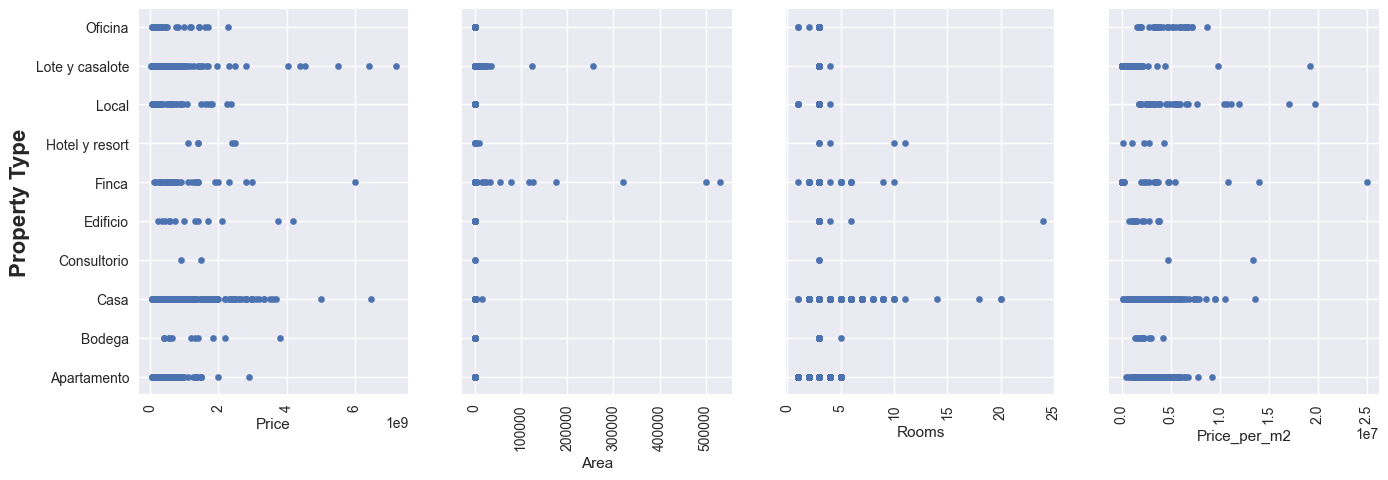

In [38]:
plt.style.use("default")
plt.style.use("seaborn")
columns = ["Price", "Area", "Rooms", "Price_per_m2"]
fig, ax = plt.subplots(1,len(columns), sharey = True, figsize=(16,5))
grouped_top = top_ten_cities_df.groupby("Property_Type")
for i in range(len(columns)):
    grouped_top.plot.scatter(x=columns[i], y="Property_Type", ax=ax[i], rot=90)
ax[0].set_ylabel("Property Type", fontdict={"fontsize":16, "fontweight":"bold"})
plt.tight_layout
plt.show()

### What is the largest property on sale?

In [39]:
print('  The largest property on sale is:')
for key, value in top_ten_cities_df.sort_values("Area", ascending=False).iloc[0].items():
    print(f"{key:<20}:{value:>15}")

  The largest property on sale is:
Property_Type       :          Finca
Price               :     1325000000
Area                :       530000.0
Rooms               :            2.0
City_name           :      Barichara
Price_per_m2        :         2500.0


### What is the most expensive property on sale?

In [40]:
print('The largest property on sale is:')
print(top_ten_cities_df.sort_values("Price", ascending=False).iloc[0])

The largest property on sale is:
Property_Type    Lote y casalote
Price                 7220000000
Area                     28875.0
Rooms                        3.0
City_name            Bucaramanga
Price_per_m2            250043.3
Name: 8, dtype: object


### Distribution of properties by type and city

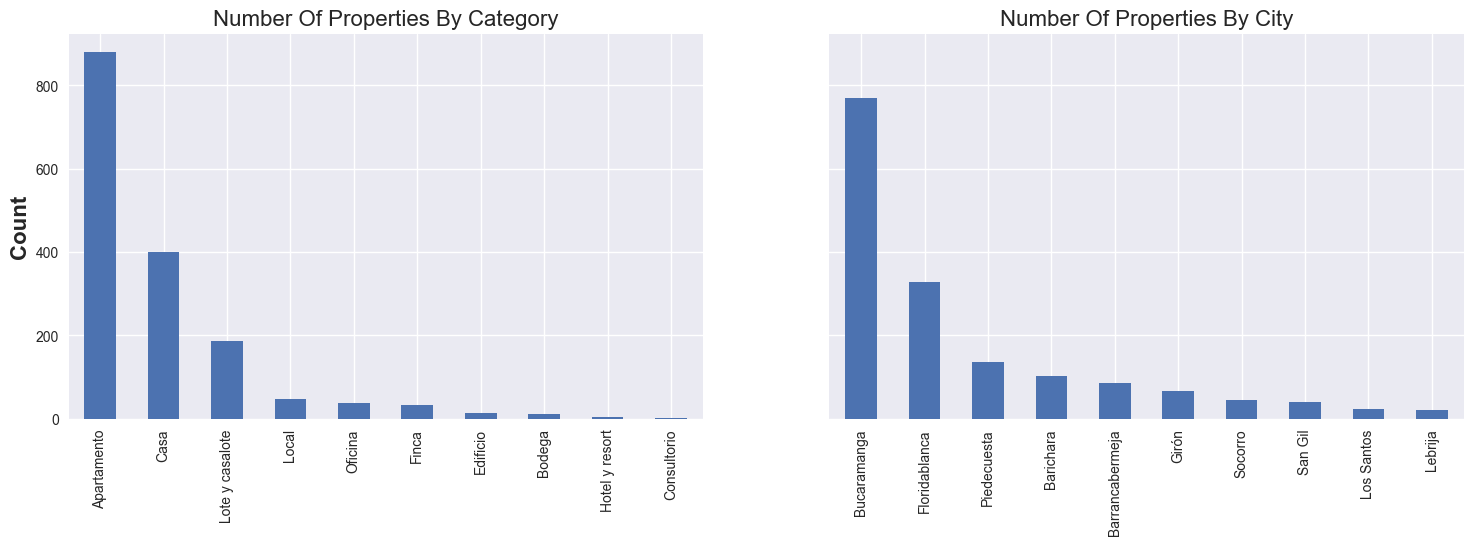

In [41]:
features = ["Property_Type", "City_name"]
fig, axs = plt.subplots(1,2, sharey=True, figsize=(18,5))
top_ten_cities_df["Property_Type"].value_counts().plot(kind="bar", ax=axs[0])
axs[0].set_ylabel("Count", fontdict={"fontsize":16, "fontweight":"bold"})
axs[0].set_title("Number of properties by category".title(), fontdict={"fontsize":16})
top_ten_cities_df["City_name"].value_counts().plot(kind="bar", ax=axs[1])
axs[1].set_title("Number of properties by city".title(), fontdict={"fontsize":16})
plt.tight_layout
plt.show()

In [42]:
properties = {key:i for i, key in enumerate(top_ten_cities_df.Property_Type.value_counts().keys())}
print(properties)

{'Apartamento': 0, 'Casa': 1, 'Lote y casalote': 2, 'Local': 3, 'Oficina': 4, 'Finca': 5, 'Edificio': 6, 'Bodega': 7, 'Hotel y resort': 8, 'Consultorio': 9}


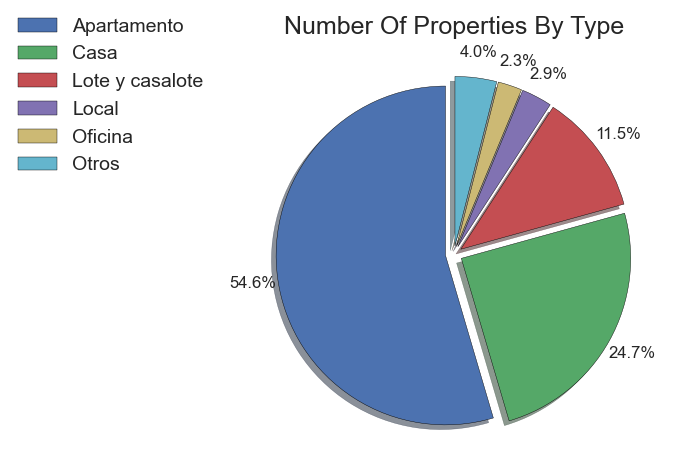

In [43]:
plt.style.use("seaborn")

n_types = 5
type_pie=list(top_ten_cities_df["Property_Type"].value_counts().nlargest(n_types).values)
type_pie.append(top_ten_cities_df["Property_Type"].value_counts().nsmallest(len(properties)-n_types).values.sum())
prop_list = list(properties.keys())[:n_types]
prop_list.append("Otros")
explode = [0.05] * (n_types + 1)

plt.pie(type_pie, shadow = True, explode=explode, wedgeprops = {"edgecolor": "black"}, autopct = "%1.1f%%", startangle=90, pctdistance=1.15, textprops={"fontsize":12})
plt.title("Number of properties by type".title(), fontsize=18)
plt.legend(labels = prop_list, bbox_to_anchor=(-0.05, 1.1), fontsize=14)
plt.show()

### Distribution of data by Price, Area and Rooms.
Both the boxplot and the histogram are great help to determine the behaviour of data and identify outliers.

[4.84215294e+08 1.98798481e+03 3.29200248e+00] [2.5e+08 6.5e+01 3.0e+00] [2.7e+08 1.0e+02 3.0e+00]
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


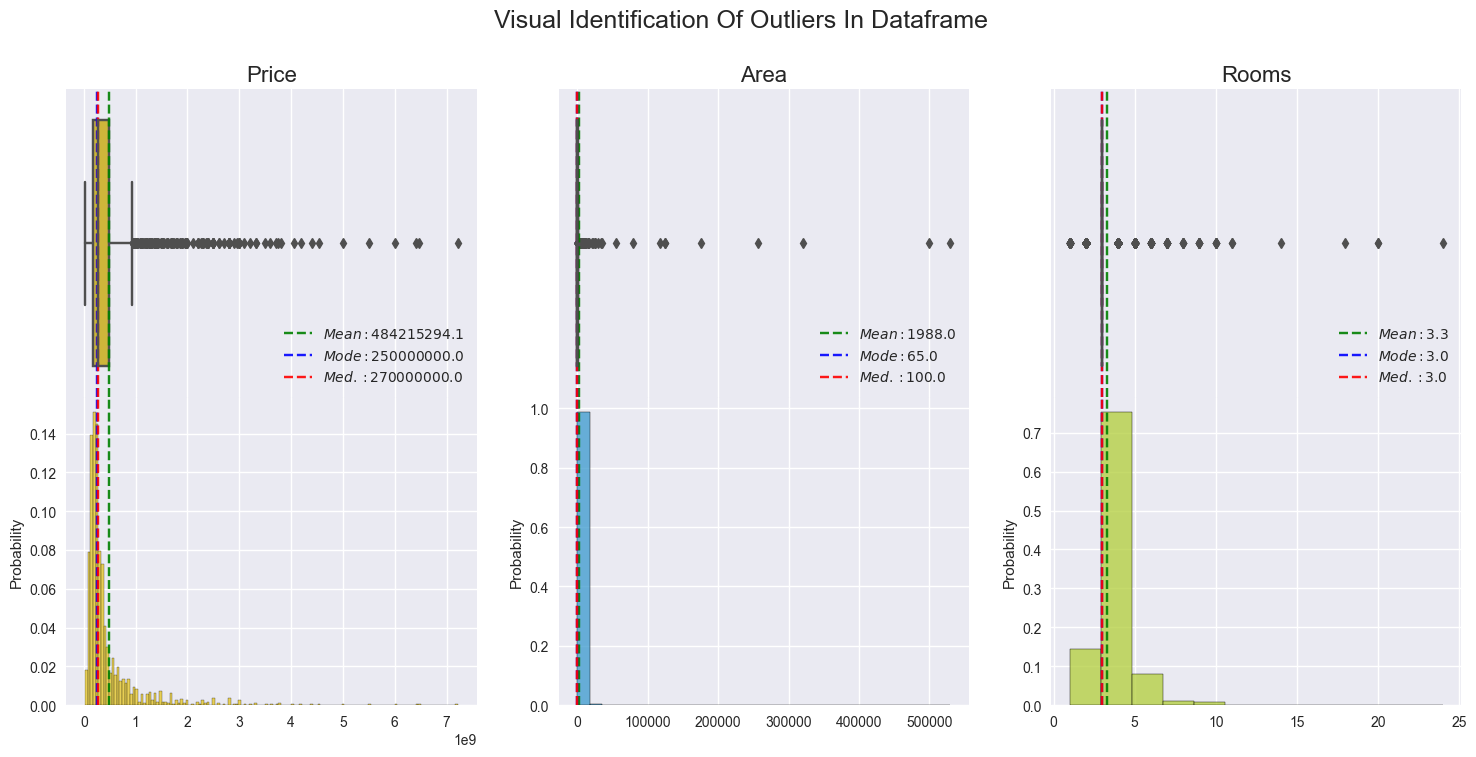

In [44]:
means1 = top_ten_cities_df[["Price","Area","Rooms"]].mean().values
modes1 = top_ten_cities_df[["Price","Area","Rooms"]].mode().values[0]
medians1 = top_ten_cities_df[["Price","Area","Rooms"]].median().values
print(means1, modes1, medians1)
print(type(means1), type(modes1), type(medians1))

columns = ["Price","Area","Rooms"]
fig, axes = plt.subplots(2,3, figsize=(18,8), sharex="col", gridspec_kw={"hspace":0})
fig.suptitle("Visual identification of outliers in dataframe".title(), fontsize=18)

sns.boxplot(ax=axes[0,0], x ="Price", data=top_ten_cities_df[["Price"]], color="#E7C621")
sns.histplot(ax=axes[1,0], x="Price",data=top_ten_cities_df[["Price"]], color="#E7C621", stat="probability").set(xlabel=None)
sns.boxplot(ax=axes[0,1], x ="Area", data=top_ten_cities_df[["Area"]], color="#3A99CE")
sns.histplot(ax=axes[1,1], x ="Area", data=top_ten_cities_df[["Area"]], bins=30, color="#3A99CE", stat="probability").set(xlabel=None)
sns.boxplot(ax=axes[0,2], x ="Rooms", data=top_ten_cities_df[["Rooms"]], color="#B2CE3A")
sns.histplot(ax=axes[1,2], x ="Rooms", data=top_ten_cities_df[["Rooms"]], color="#B2CE3A", stat="probability").set(xlabel=None)

for i in range(axes.size):
    i, j = i//3, i% 3  # i for rows, j for columns
    axes[0,j].legend(loc="lower right")
    axes[0,j].set_title("{}".format(columns[j]), fontsize=16)
    axes[i,j].axvline(x=means1[j], color='g', linestyle='--', alpha = 0.9, label = f"$Mean:{means1[j]:>.1f}$")
    axes[i,j].axvline(x=modes1[j], color='b', linestyle='--', alpha = 0.9, label = f"$Mode:{modes1[j]:>.1f}$") 
    axes[i,j].axvline(x=medians1[j],  color='r', linestyle='--', alpha = 0.9, label = f"$Med.:{medians1[j]:>.1f}$") 
  
plt.show()


The three features exhibit a right-skewed distribution since ```Mean > Median > Mode```

In [ ]:
# To save changes if needed.
# top_ten_cities_df.to_csv("fincas_sder_mercado_final", index=False)

### Relationship between Features
Now, it is time to see the dependence or correlation among features.

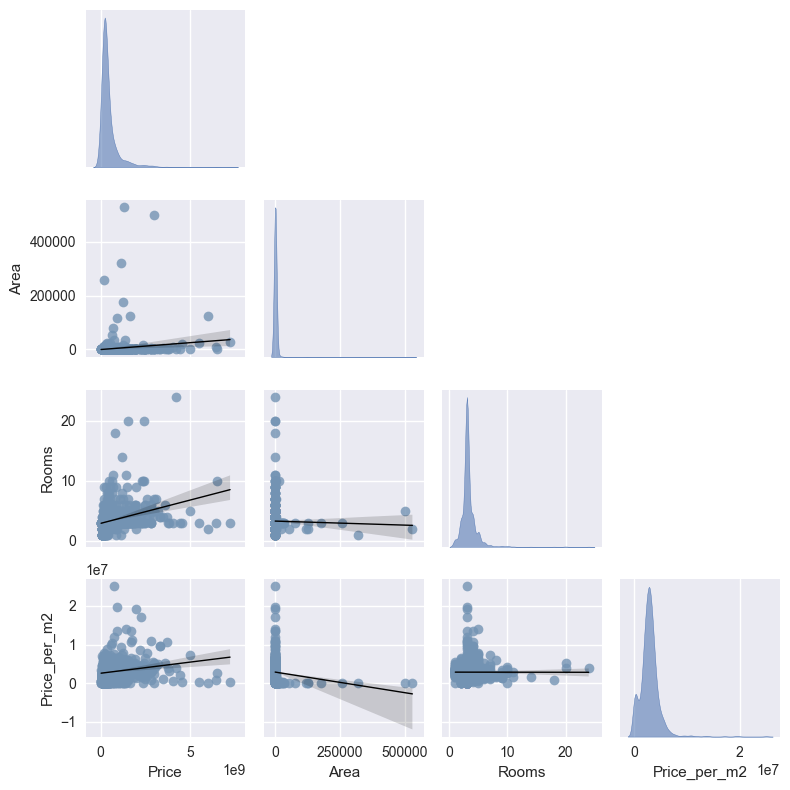

In [45]:
sns.pairplot(top_ten_cities_df, kind="reg", height = 2, diag_kind = "kde", plot_kws={'color':"#7393B3", "line_kws":{"color":"k", "linewidth":1}} , diag_kws = {'alpha':0.55}, corner = True)
plt.tight_layout()

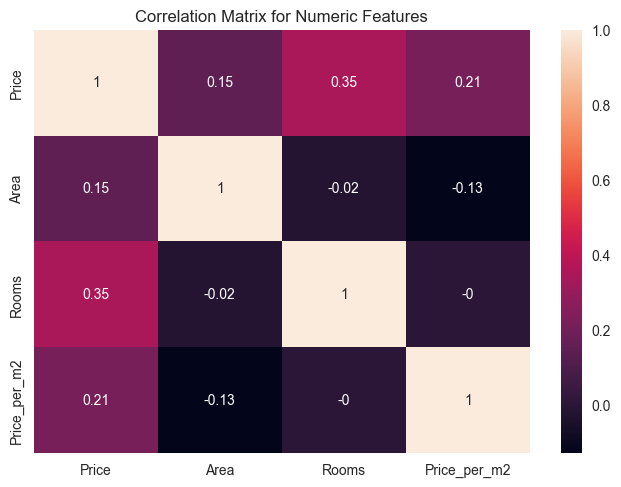

In [46]:
# Correlation matrix between all numeric columns

correlation_matrix_sder = top_ten_cities_df.corr(method="pearson").round(2)
sns.heatmap(correlation_matrix_sder, annot = True)
plt.title("Correlation Matrix for Numeric Features")
plt.show()

Both the pairplot and the correlation matrix show no strong correlation between numeric features. Hence, let's include categorical variables and see what happens.

C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16208\618165564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ten_cities_df[cat_columns] = top_ten_cities_df[cat_columns].apply(lambda x: pd.factorize(x)[0])


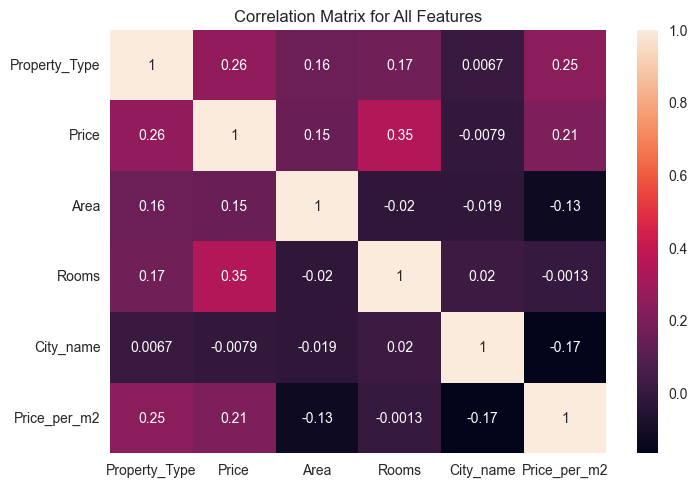

In [47]:
#get all categorical columns
cat_columns = top_ten_cities_df.select_dtypes(['object']).columns

# Using factorize to assign a numeric value for eah unique categorial value
top_ten_cities_df[cat_columns] = top_ten_cities_df[cat_columns].apply(lambda x: pd.factorize(x)[0])
corr_matrix_2 = top_ten_cities_df.corr(method="pearson")
sns.heatmap(corr_matrix_2, annot = True)
plt.title("Correlation Matrix for All Features")
plt.show()

In [48]:
# Retrieve those with significant correlation [-1,-0.5) U (0.5,1]
sorted_pairs = corr_matrix_2.unstack().sort_values(kind="quicksort")
corr_pairs = sorted_pairs[abs(sorted_pairs) > 0.5]
print(corr_pairs)

Rooms          Rooms           1.0
City_name      City_name       1.0
Area           Area            1.0
Property_Type  Property_Type   1.0
Price_per_m2   Price_per_m2    1.0
Price          Price           1.0
dtype: float64


Unfortunately, there are no features with strong correlation beside the diagonal elements. However, it is worth noting that *Price* and *Rooms* have a correlation of 0.35

## Visualizations

In [49]:
# reload the dataset in case String columns have been transformed to numeric value via factorize function
# top_ten_cities_df = pd.read_csv("fincas_sder_mercado_final")
# top_ten_cities_df.head(10)

In [50]:
sum_top_ten = top_ten_cities_df.groupby(["Property_Type","City_name"], as_index=False).agg({"Price":"count","Area":"median","Rooms":"median","Price_per_m2":"median"})
sum_top_ten.head()

,Property_Type,City_name,Price,Area,Rooms,Price_per_m2
0,Apartamento,Barichara,1,191.0,3.0,670157.1
1,Apartamento,Barrancabermeja,53,70.0,3.0,2581751.3
2,Apartamento,Bucaramanga,521,78.0,3.0,3142857.1
3,Apartamento,Floridablanca,187,80.0,3.0,3070175.4
4,Apartamento,Girón,36,61.5,3.0,2358123.6


C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_16208\896866387.py:11: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate(row['Price'], (row['City_name'], row['Property_Type']), textcoords='offset points' , fontsize=8)


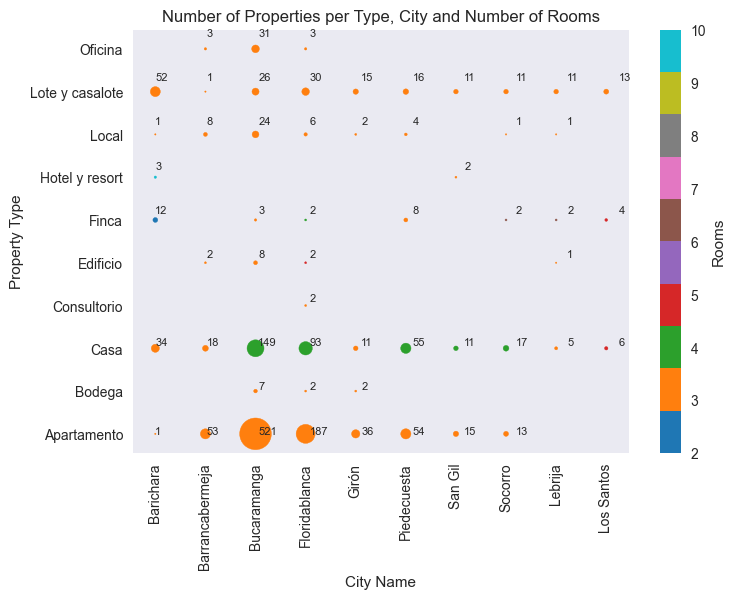

In [51]:
plt.style.use("seaborn-dark")
fig, ax = plt.subplots()
ax.grid(linewidth=0.1)
scatter1 = sum_top_ten.plot.scatter(x="City_name", y="Property_Type",s="Price", c="Rooms", ax=ax, rot=90, colormap="tab10")
ax.set_xlabel("City Name")
ax.set_ylabel("Property Type")
ax.set_title("Number of Properties per Type, City and Number of Rooms")

# annotate points in axis
for idx, row in sum_top_ten.iterrows():
    ax.annotate(row['Price'], (row['City_name'], row['Property_Type']), textcoords='offset points' , fontsize=8)

plt.show()

The point size and its annotation indicate the number of properties per subcategory. Similarly, the color reflects the median number of rooms, for example:

- The plot indicates that Bucaramanga is the city with the largest number of properties on sale. Also, 521 out of the 793 properties are apartments with a median number of rooms of 3.
- In Piedecuesta, 55 houses "casas" are on sale, and their median number of rooms is 4.



### Price per m2 by City and Property type

In [53]:
type_city_price = pd.pivot_table(top_ten_cities_df, index=["Property_Type"], columns=["City_name"], values="Price_per_m2",aggfunc='median')
type_city_price.head()

City_name,Barichara,Barrancabermeja,Bucaramanga,Floridablanca,Girón,Lebrija,Los Santos,Piedecuesta,San Gil,Socorro
Property_Type,,,,,,,,,,
Apartamento,670157.1,2581751.3,3142857.1,3070175.4,2358123.6,NaN,NaN,2451396.3,2130434.8,2236842.1
Bodega,NaN,NaN,2037037.0,2891836.7,2220000.0,NaN,NaN,NaN,NaN,NaN
Casa,2890625.0,1931944.4,2714285.7,2800000.0,2100000.0,1782211.9,1272388.1,2786885.2,1797385.6,2222222.2
Consultorio,NaN,NaN,NaN,9063812.6,NaN,NaN,NaN,NaN,NaN,NaN
Edificio,NaN,1385489.8,2541666.7,1100421.9,NaN,1206896.6,NaN,NaN,NaN,NaN


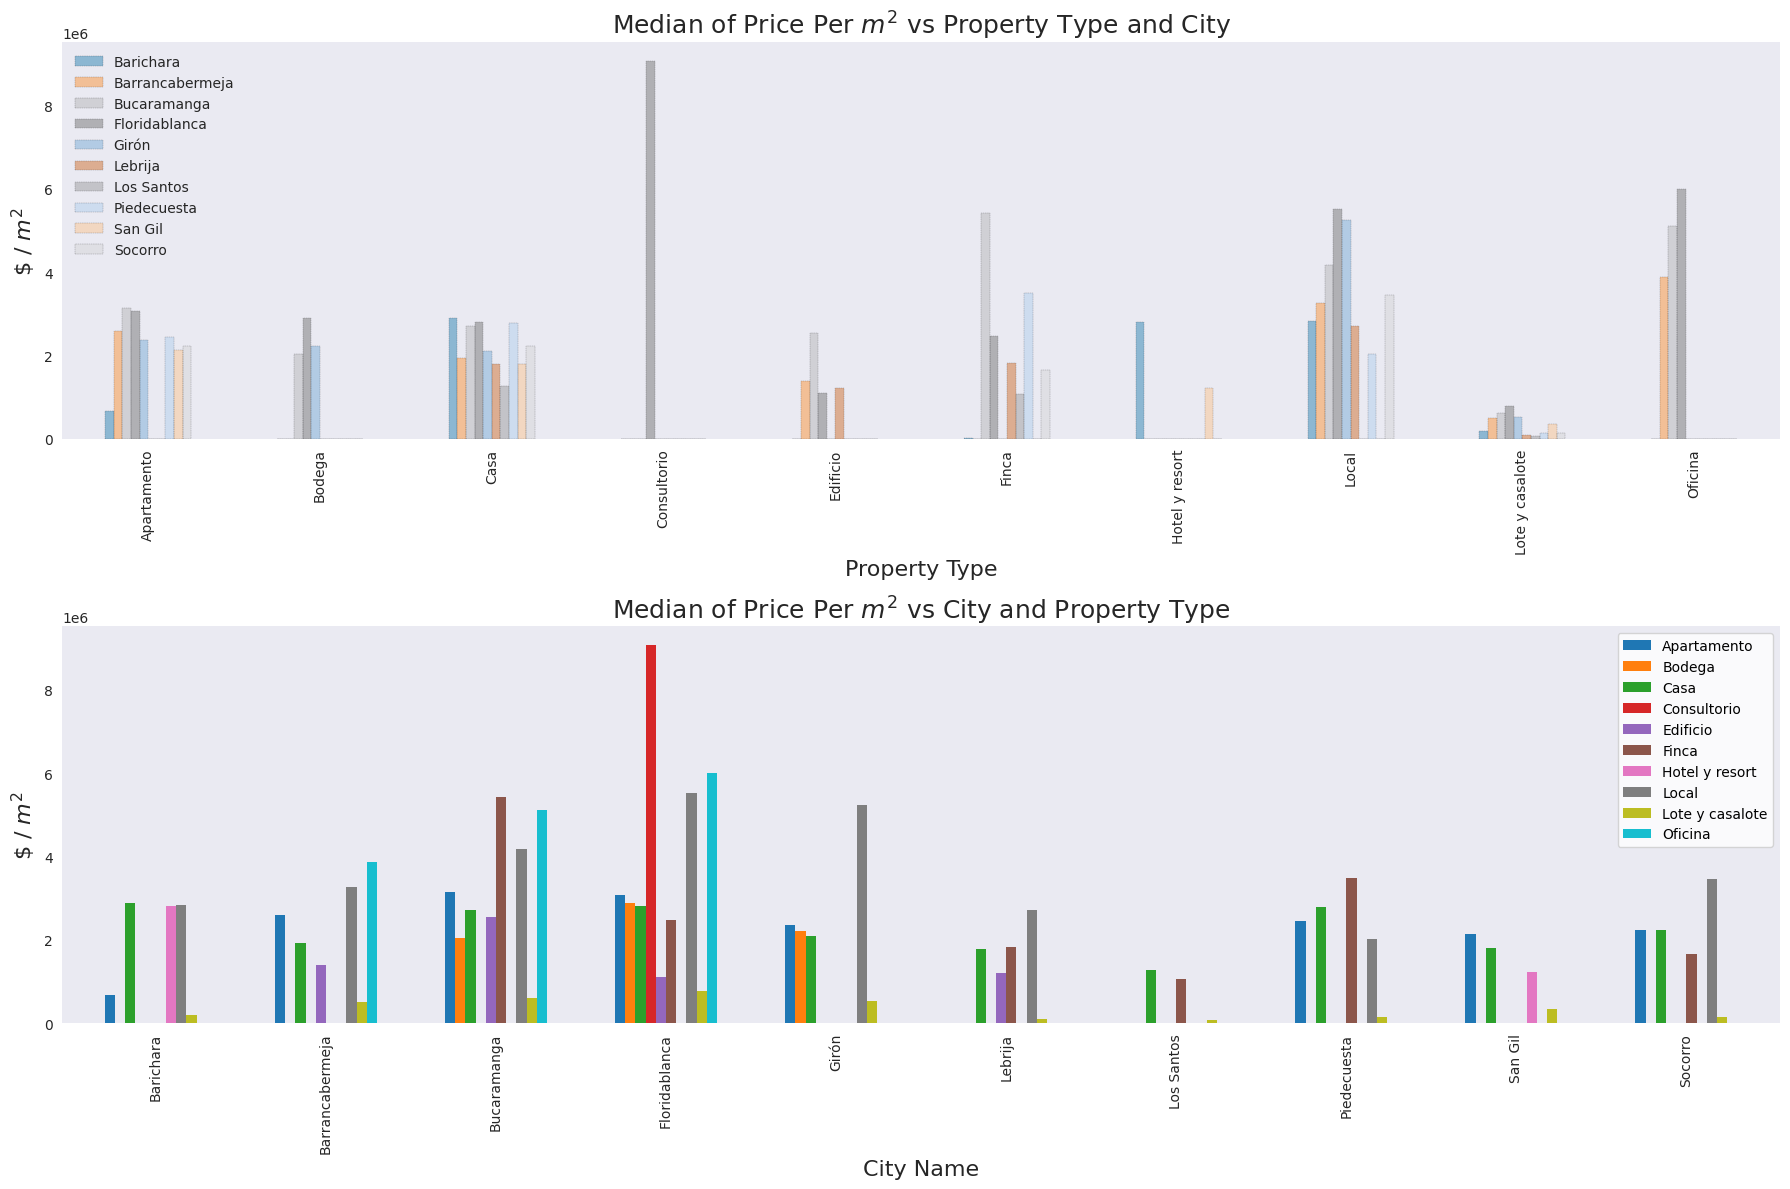

In [54]:
plt.style.use("tableau-colorblind10")
fig, axes = plt.subplots(2, 1, figsize=(18,12))

type_city_price.plot.bar(ax=axes[0], grid=False, alpha=0.4, linestyle="--", edgecolor="k")
axes[0].set_title("Median of Price Per $m^2$ vs Property Type and City", fontsize=18)
axes[0].set_ylabel("\$ / $m^2$", fontsize=16)
axes[0].set_xlabel("Property Type", fontsize=16)
axes[0].legend(loc="best")

plt.style.use("default")
type_city_price.T.plot.bar(ax = axes[1], width=0.6)
axes[1].set_title("Median of Price Per $m^2$ vs City and Property Type", fontsize=18)
axes[1].set_ylabel("\$ / $m^2$", fontsize=16)
axes[1].set_xlabel("City Name", fontsize=16)
axes[1].legend(loc="best")
plt.tight_layout(h_pad=1)
plt.show()

From upper panel

**Which city is the most affordable to buy an apartment?**
Barichara\
**Which city is the most expensive to buy an office?**
Floridablanca\
**Which property type has the highest price per square meter?**
Consultorio\
**And the lowest?**
Lote y casalote

From lower panel

**Which city has the lowest prices per square meter?**
Los Santos\
**And the highest?**
Floridablanca\
**What property type sells at the lowest price /m2 in Bucaramanga?**
Lote y casalote

Thanks for making it to the end. Any comments or suggestions are welcome.